**Imports**

In [84]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, average_precision_score

**Load Data**

In [85]:
data = pd.read_csv("./dataset.csv")

# dataset 2
data_test = pd.read_csv("./dataset_test.csv")

# data["label"].value_counts()
# data.shape

**Split Data**

In [86]:
# SPLIT 80-20 Train-Test from FULL dataset
# for DATASER 1 and 3
# X_train, X_test, y_train, y_test = train_test_split(data.drop("label", axis=1), data["label"], test_size=0.2, random_state=35)

# for DATASET 2
X_train, y_train = data.drop("label", axis=1), data["label"]
X_test, y_test = data_test.drop("label", axis=1), data_test["label"]

# SPLIT 80-20 Train-Validation from TRAIN dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=35)

**Normal LR**

In [87]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
    
tn = cm[0, 0]
fp = cm[0, 1]

AUROC = roc_auc_score(y_test, y_score)
AUPR = average_precision_score(y_test, y_score)

specificity = tn / (tn + fp)

print("Accuracy:", accuracy)
print("Sensitivity:", recall)
print("Specificity:", specificity)
print("Precision:", precision)
print("F1-score:", f1)
print("AUROC:", AUROC)
print("AUPR:", AUPR)

Accuracy: 0.850316319636386
Sensitivity: 0.5912636505460218
Specificity: 0.9304382790510656
Precision: 0.7244345332908569
F1-score: 0.651109520400859
AUROC: 0.9016250597752097
AUPR: 0.7485082980388065


# Logistic Regression class

In [88]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, regularization="l1", regularization_strength=0):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.regularization = regularization
        self.regularization_strength = regularization_strength
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        no_examples, no_features = X.shape
        self.weights = np.zeros(no_features)
        self.bias = 0

        for _ in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            gradient = (1 / no_examples) * np.dot(X.T, (y_pred - y))
            bias_gradiant = (1 / no_examples) * np.sum(y_pred - y)

            # Regularization
            if self.regularization == "l1":
                gradient += (self.regularization_strength / no_examples) * np.sign(self.weights)
            elif self.regularization == "l2":
                gradient += (2 * self.regularization_strength / no_examples) * self.weights

            self.weights -= self.learning_rate * gradient
            self.bias -= self.learning_rate * bias_gradiant

    def predict(self, X):
        y_pred = self.predict_proba(X)
        return np.round(y_pred)
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return y_pred


# Bagging

In [89]:
class Bagging:
    def __init__(self, model_count):
        self.model_count = model_count

    def resample(self, X_train, y_train):
        length = len(X_train)

        X_train_resampled = pd.DataFrame()
        y_train_resampled = []

        for i in range(length):
            rand = random.randint(0, length - 1)
            row_to_append = X_train.iloc[rand] 
            X_train_resampled = pd.concat([X_train_resampled, row_to_append.to_frame().T], ignore_index=True)
            y_train_resampled.append(y_train.iloc[rand])

        return X_train_resampled, y_train_resampled

    def get_LR_learners(self, X_train, y_train):
        base_lr = []

        for _ in range(self.model_count):
            X_train_bag, y_train_bag = self.resample(X_train, y_train)

            lr = LogisticRegression(
                learning_rate=50,
                num_iterations=100
            )
            lr.fit(X_train_bag, y_train_bag)

            base_lr.append(lr)

        return base_lr


In [90]:
model_count = 9
bag_generator = Bagging(model_count)
base_lr = bag_generator.get_LR_learners(X_train, y_train)

# Report

In [91]:
def report(y_true, y_pred, y_score):

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    auroc = roc_auc_score(y_true, y_score)
    aupr = average_precision_score(y_true, y_score)

    cm = confusion_matrix(y_true, y_pred)
    
    tn = cm[0, 0]
    fp = cm[0, 1]
    
    specificity = tn / (tn + fp)

    print("Accuracy:", accuracy)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("Precision:", precision)
    print("F1-score:", f1)
    print("AUROC:", auroc)
    print("AUPR:", aupr)

    return [accuracy, sensitivity, specificity, precision, f1, auroc, aupr]

**Report of LR's**

In [92]:
scores = []

for i, model in enumerate(base_lr):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    print(f"\n\nModel {i + 1}")
    print("---------------\n")
    scores.append(report(y_test, y_pred, y_score))



Model 1
---------------

Accuracy: 0.7974325901357411
Sensitivity: 0.7979719188767551
Specificity: 0.797265782066747
Precision: 0.5490161001788909
F1-score: 0.6504874947011445
AUROC: 0.8829575780538258
AUPR: 0.6895071578820227


Model 2
---------------

Accuracy: 0.7488483508384006
Sensitivity: 0.8627145085803433
Specificity: 0.7136308805790108
Precision: 0.4823375490623637
F1-score: 0.6187412587412587
AUROC: 0.8732793992097441
AUPR: 0.6466202531228351


Model 3
---------------

Accuracy: 0.8328726736686936
Sensitivity: 0.4713988559542382
Specificity: 0.9446722959388821
Precision: 0.7249100359856058
F1-score: 0.5712935244997637
AUROC: 0.8788449286262565
AUPR: 0.6865113293566071


Model 4
---------------

Accuracy: 0.7484184018180702
Sensitivity: 0.8788351534061363
Specificity: 0.7080820265379976
Precision: 0.48216833095577744
F1-score: 0.6226971260132645
AUROC: 0.8763587294597535
AUPR: 0.6540809690590842


Model 5
---------------

Accuracy: 0.7796204164363368
Sensitivity: 0.081123244

# Violin plotting

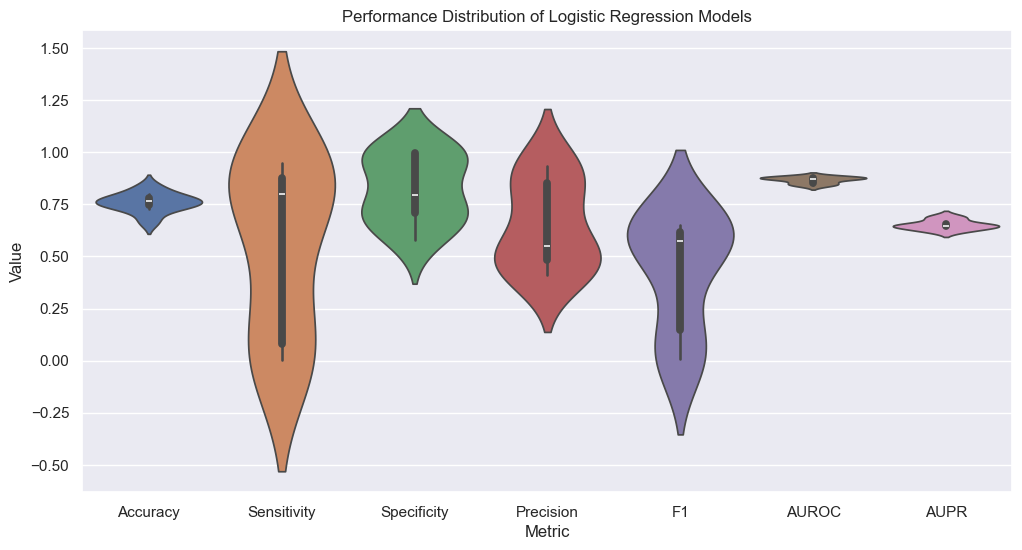

In [93]:
df_violin = pd.DataFrame(scores, columns=["Accuracy", "Sensitivity", "Specificity", "Precision", "F1", "AUROC", "AUPR"])

sns.set_theme()
plt.figure(figsize=(12, 6))

sns.violinplot(data=df_violin)

plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Performance Distribution of Logistic Regression Models")

plt.show()

In [94]:
accuracy = []
sensitivity = []
specificity = []
precision = []
f1 = []
auroc = []
aupr = []

for i, score in enumerate(scores):
    accuracy.append(score[0])
    sensitivity.append(score[1])
    specificity.append(score[2])
    precision.append(score[3])
    f1.append(score[4])
    auroc.append(score[5])
    aupr.append(score[6])

accuracy = np.array(accuracy)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
precision = np.array(precision)
f1 = np.array(f1)
auroc = np.array(auroc)
aupr = np.array(aupr)
    
print(f"\n\nModel LR's")
print(f"----------------\n")
print(f"Accuracy: --- Average:{accuracy.mean():.4f} --- Standard deviation: {accuracy.std():.4f}")
print(f"Sensitivity: --- Average:{sensitivity.mean():.4f} --- Standard deviation: {sensitivity.std():.4f}")
print(f"Specificity: --- Average: {specificity.mean():.4f} --- Standard deviation: {specificity.std():.4f}")
print(f"Precision: --- Average: {precision.mean():.4f} --- Standard deviation: {precision.std():.4f}")
print(f"F1-score: --- Average: {f1.mean():.4f} --- Standard deviation: {f1.std():.4f}")
print(f"AUROC: --- Average: {auroc.mean():.4f} --- Standard deviation: {auroc.std():.4f}")
print(f"AUPR: --- Average: {aupr.mean():.4f} --- Standard deviation: {aupr.std():.4f}")



Model LR's
----------------

Accuracy: --- Average:0.7591 --- Standard deviation: 0.0434
Sensitivity: --- Average:0.5508 --- Standard deviation: 0.3907
Specificity: --- Average: 0.8235 --- Standard deviation: 0.1544
Precision: --- Average: 0.6470 --- Standard deviation: 0.2005
F1-score: --- Average: 0.4241 --- Standard deviation: 0.2639
AUROC: --- Average: 0.8674 --- Standard deviation: 0.0148
AUPR: --- Average: 0.6522 --- Standard deviation: 0.0215


**Meta Dataset Builder**

In [95]:
def meta_dataset_builder(base_lr, X_):
    meta_train_features = X_.copy()    

    for i, model in enumerate(base_lr):
        prediction = model.predict(X_)
        meta_train_features[f'lr_learner_{i}'] = prediction

    return meta_train_features

# Stacking

In [132]:
def stacking(base_lr, X_val, y_val):

    meta_train_features = meta_dataset_builder(base_lr, X_val)

    meta_classifier = LogisticRegression(
        learning_rate=1.5,
        num_iterations=100
    )

    meta_classifier.fit(meta_train_features, y_val)

    return meta_classifier

In [133]:
meta_classifier = stacking(base_lr, X_val, y_val)

# Test

In [134]:
def test_data(meta_classifier, X_test):

    meta_test_features = meta_dataset_builder(base_lr, X_test)
    stacking_preds = meta_classifier.predict(meta_test_features)
    y_score = meta_classifier.predict_proba(meta_test_features)
    
    return stacking_preds, y_score

In [135]:
stacking_preds, y_score = test_data(meta_classifier, X_test)    

# Majority Voting Classification

In [136]:
class MajorityVoting:
    def __init__(self, base_lr):
        self.base_lr = base_lr

    def majority_voting_df_builder(self, X_test):
        majority_voting_df = []

        for i, model in enumerate(self.base_lr):
            prediction = model.predict(X_test)
            majority_voting_df.append(prediction)

        return majority_voting_df

    def majority_voting_classifier(self, X_test):
        majority_voting_df = self.majority_voting_df_builder(X_test)

        majority_voting_preds = []
        for i in range(len(majority_voting_df[0])):
            ONE = 0
            ZERO = 0
            for j in range(len(majority_voting_df)):
                if majority_voting_df[j][i] == 1:
                    ONE += 1
                else:
                    ZERO += 1
            if ONE > ZERO:
                majority_voting_preds.append(1)
            else:
                majority_voting_preds.append(0)

        return majority_voting_preds

In [137]:
mv_model = MajorityVoting(base_lr)
majority_voting_preds = mv_model.majority_voting_classifier(X_test)

# Report

In [138]:
print("Majority Voting")
print("-----------------\n")
mv_score = report(y_test, majority_voting_preds, majority_voting_preds)
print("\nEnsemble Stacking")
print("-----------------\n")
se_score = report(y_test, stacking_preds, y_score)

Majority Voting
-----------------

Accuracy: 0.7979853817333088
Sensitivity: 0.797451898075923
Specificity: 0.7981503819863289
Precision: 0.5499372422449346
F1-score: 0.6509604160033959
AUROC: 0.797801140031126
AUPR: 0.4863956814847786

Ensemble Stacking
-----------------

Accuracy: 0.8320741969166513
Sensitivity: 0.4872594903796152
Specificity: 0.9387213510253317
Precision: 0.7109256449165402
F1-score: 0.578216599814872
AUROC: 0.87736578622775
AUPR: 0.6821794804796661
